In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors=ap.COLORS

In [2]:
region="TWP"
chunk_dict={"time":50, "ncol":2000, "lev":50}

In [3]:
z_sc = xr.open_dataset(ap.get_fldmean_file("SCREAM","TWP","zg")).zg
z_um = xr.open_dataset(ap.get_fldmean_file("UM","TWP","zg")).zg
z_ge = xr.open_dataset(ap.get_fldmean_file("GEOS","TWP","zg")).zg.mean(axis=(0,2,3))

In [4]:
# z_sc
# z_um
z_ge.shape

(181,)

In [5]:
models=["SCREAM", "NICAM", "UM", "SAM", "GEOS"]

## create dictionaries with models as keys for each variable 
## cli = cloud ice, clw = cloud water, ta = temperature, hus = specific humidity
cli_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "cli")).cli.mean(axis=(0,2,3)) for m in models]))
clw_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "clw")).clw.mean(axis=(0,2,3)) for m in models]))
ta_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "ta")).ta.median(axis=(0,2,3)) for m in models]))
hus_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "hus")).hus.median(axis=(0,2,3)) for m in models]))

## get snow and graupel for NICAM
clsg_ni = xr.open_dataset(ap.get_fldmean_file("NICAM", region, "snowmxrat")).snowmxrat.mean(axis=(0,2,3)) + \
       xr.open_dataset(ap.get_fldmean_file("NICAM", region, "grplmxrat")).grplmxrat.mean(axis=(0,2,3))
cls_ge = xr.open_dataset(ap.get_fldmean_file("GEOS", region, "snowmxrat")).snowmxrat.mean(axis=(0,2,3))

## get total frozen hydrometeors
cli_dict["NICAM"] = cli_dict["NICAM"]+ clsg_ni
cli_dict["GEOS"]  = cli_dict["GEOS"] + cls_ge

## SAM has qv in g/kg - convert to kg/kg
hus_dict["SAM"] = hus_dict["SAM"]/1000

big_dict = {"cli":cli_dict, "clw":clw_dict, "ta":ta_dict, "hus":hus_dict}


In [6]:
clw_dict["GEOS"].shape

(181,)

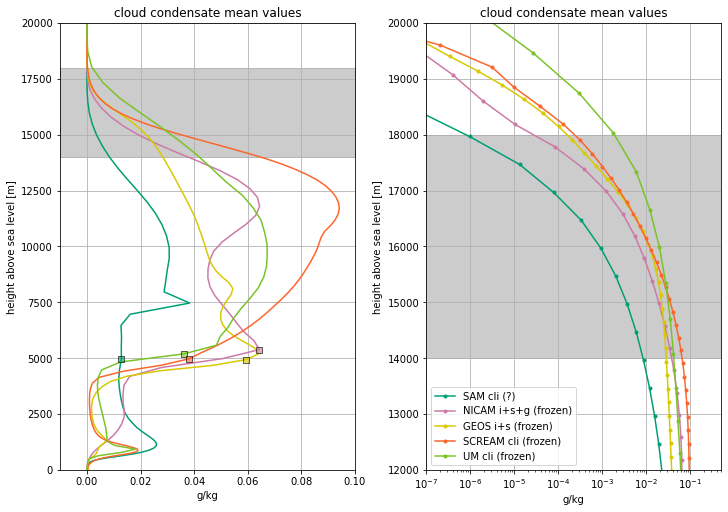

In [7]:

#### height given in file ####
cliw={}
m="SAM"
z = "z"
fig, [ax, axt] = plt.subplots(1,2, figsize=(10,7), constrained_layout=True)
# clw_dict[m].plot(y=z, ax=ax, color=colors[m], linestyle="--")
# cli_dict[m].plot(y=z, ax=ax, color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])
cliw[m].plot(y=z, ax=ax, color=colors[m])
cliw[m].plot(y=z, ax=axt, color=colors[m], marker=".", label=m+" cli (?)")

m="NICAM"
z = "lev"
# ((clw_dict[m])*1000).plot(y=z, ax=ax, color=colors[m], linestyle="--")
# ((cli_dict[m])*1000).plot(y=z, ax=ax, color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])*1000
cliw[m].plot(y=z, ax=ax, color=colors[m])
cliw[m].plot(y=z, ax=axt, color=colors[m], marker=".", label=m+" i+s+g (frozen)")

### height from zg output ###
m="GEOS"
# ax.plot((clw_dict[m]*1000)[:-1], sc_z, color=colors[m], linestyle="--")
# ax.plot((cli_dict[m]*1000)[:-1], sc_z, color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])*1000
ax.plot((cliw[m]), z_ge, color=colors[m])
axt.plot((cliw[m]), z_ge, color=colors[m], marker=".", label=m+" i+s (frozen)")

##### calculated height #####
m="SCREAM"
# ax.plot((clw_dict[m]*1000)[:-1], sc_z, color=colors[m], linestyle="--")
# ax.plot((cli_dict[m]*1000)[:-1], sc_z, color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])*1000
ax.plot((cliw[m])[:-1], z_sc, color=colors[m])
axt.plot((cliw[m])[:-1], z_sc, color=colors[m], marker=".", label=m+" cli (frozen)")

m="UM"
# ax.plot((clw_dict[m]*1000)[:-1], um_z, color=colors[m], linestyle="--")
# ax.plot((cli_dict[m]*1000)[:-1], um_z, color=colors[m], linestyle=":")
cliw[m] = (clw_dict[m]+cli_dict[m])*1000
ax.plot(cliw[m][:-1], z_um, color=colors[m])
axt.plot(cliw[m][:-1], z_um, color=colors[m], marker=".", label=m+" cli (frozen)")

i_um = np.argmin(abs(ta_dict["UM"].values-273))
i_sc = np.argmin(abs(ta_dict["SCREAM"].values-273))
i_ni = np.argmin(abs(ta_dict["NICAM"].values-273))
i_sa = np.argmin(abs(ta_dict["SAM"].values-273))
i_ge = np.argmin(abs(ta_dict["GEOS"].values-273))

ax.scatter(cliw["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cliw["NICAM"][i_ni], clw_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cliw["SAM"][i_sa], clw_dict["SAM"].z[i_sa], color=colors["SAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cliw["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(cliw["GEOS"][i_ge], z_ge[i_ge], color=colors["GEOS"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)


ax.fill_between([-1e-2,1e-1],14000,18000,color="k",alpha=0.2)
ax.set_title("cloud condensate mean values")
ax.set_xlabel("g/kg")
ax.grid()
axt.fill_between([-1e-2,1],14000,18000,color="k",alpha=0.2)
axt.set_title("cloud condensate mean values")
axt.set_xlabel("g/kg")
axt.grid()

ax.set_xlim([-1e-2,1e-1])
ax.set_ylim([0,20000])

axt.legend(loc="lower left")
axt.set_xlim([1e-7,0.5])
axt.set_ylim([12000, 20000])
axt.set_xscale("log")
plt.savefig("../plots/TWP/TWP_3D_cli+clw_mean.png", dpi=120)

plt.show()

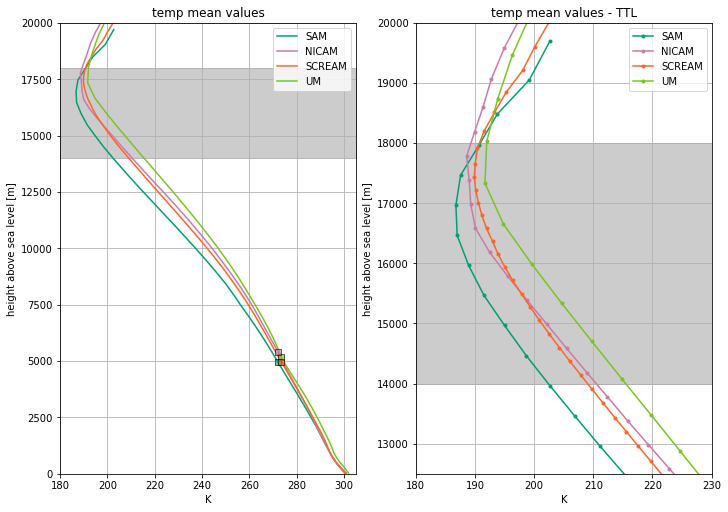

In [8]:
fig, [ax, axt] = plt.subplots(1,2, figsize=(10,7), constrained_layout=True)
m="SAM"
z = "z"
(ta_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(ta_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="NICAM"
z = "lev"
(ta_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(ta_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="SCREAM"
z = "lev"
ax.plot((ta_dict[m])[:-1], z_sc, color=colors[m], label=m)
axt.plot((ta_dict[m])[:-1], z_sc, color=colors[m], label=m, marker=".")
m="UM"
ax.plot(ta_dict[m][:-1], z_um, color=colors[m], label=m)
axt.plot(ta_dict[m][:-1], z_um, color=colors[m], label=m, marker=".")
# m="GEOS"
# ax.plot(ta_dict[m][:-1], z_ge, color=colors[m], label=m)
# axt.plot(ta_dict[m][:-1], z_ge, color=colors[m], label=m)

ax.scatter(ta_dict["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(ta_dict["NICAM"][i_ni], clw_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(ta_dict["SAM"][i_sa], clw_dict["SAM"].z[i_sa], color=colors["SAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(ta_dict["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)


ax.fill_between([180,305],14000,18000,color="k",alpha=0.2)
axt.fill_between([180,305],14000,18000,color="k",alpha=0.2)


ax.legend(loc="upper right")
axt.legend(loc="upper right")
ax.set_xlim([180,305])
ax.set_ylim([0,20000])
axt.set_xlim([180,230])
axt.set_ylim([12500,20000])
axt.set_title("temp mean values - TTL")
axt.set_xlabel("K")
ax.set_title("temp mean values")
ax.set_xlabel("K")
ax.grid(True)
axt.grid(True)
plt.savefig("../plots/TWP/TWP_3D_ta_mean.png", dpi=120)
plt.show()

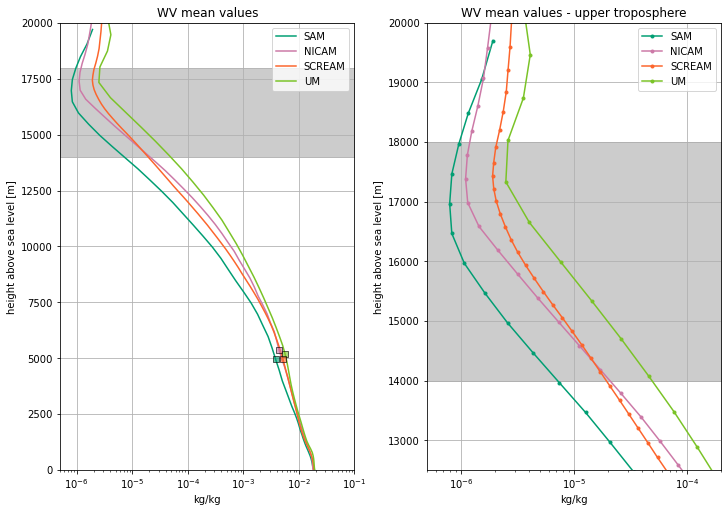

In [9]:
fig, [ax, axt] = plt.subplots(1,2, figsize=(10,7), constrained_layout=True)
m="SAM"
z = "z"
(hus_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(hus_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="NICAM"
z = "lev"
(hus_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(hus_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="SCREAM"
z = "lev"
ax.plot((hus_dict[m])[:-1], z_sc, color=colors[m], label=m)
axt.plot((hus_dict[m])[:-1], z_sc, color=colors[m], label=m, marker=".")
m="UM"
ax.plot(hus_dict[m][:-1], z_um, color=colors[m], label=m)
axt.plot(hus_dict[m][:-1], z_um, color=colors[m], label=m, marker=".")

ax.scatter(hus_dict["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(hus_dict["NICAM"][i_ni], clw_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(hus_dict["SAM"][i_sa], clw_dict["SAM"].z[i_sa], color=colors["SAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(hus_dict["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)

ax.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)
axt.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)

ax.legend(loc="upper right")
axt.legend(loc="upper right")
ax.set_xscale("log")
axt.set_xscale("log")
ax.set_xlim([5e-7,1e-1])
ax.set_ylim([0,20000])
axt.set_xlim([5e-7,2e-4])
axt.set_ylim([12500,20000])
axt.set_title("WV mean values - upper troposphere")
axt.set_xlabel("kg/kg")
ax.set_title("WV mean values")
ax.set_xlabel("kg/kg")
ax.grid(True)
axt.grid(True)
plt.savefig("../plots/TWP/TWP_3D_hus_mean.png", dpi=120)
plt.show()

In [10]:
ta_dict["SAM"]

<xarray.DataArray 'ta' (z: 61)>
array([300.8979 , 300.403  , 299.9937 , 299.58337, 299.14166, 298.6828 ,
       298.21057, 297.7256 , 297.23056, 296.75714, 296.27594, 295.8008 ,
       295.3269 , 294.8377 , 294.37097, 293.8777 , 293.34222, 292.7829 ,
       292.1751 , 291.5326 , 290.8098 , 290.0467 , 289.1704 , 288.21753,
       287.0688 , 285.70966, 284.1636 , 282.31268, 280.18335, 277.6622 ,
       274.86725, 272.02698, 269.1534 , 266.1924 , 263.10712, 259.82904,
       256.4212 , 253.20734, 249.70888, 245.81403, 241.74402, 237.52   ,
       233.22015, 228.82932, 224.39053, 219.93616, 215.47748, 211.07431,
       206.81737, 202.6514 , 198.65054, 194.99405, 191.51624, 188.91266,
       186.97644, 186.76416, 187.5639 , 190.67322, 193.77194, 199.17957,
       202.68158], dtype=float32)
Coordinates:
  * z        (z) float32 20.0 61.2 104.9 151.2 ... 1.848e+04 1.905e+04 1.97e+04

In [ ]:
var_key = "rh_ice"
var = big_dict[var_key]

fig, [ax, axt] = plt.subplots(1,2, figsize=(10,7), constrained_layout=True)

# m="SAM"
# z = "z"
# (var[m]).plot(y=z, ax=ax, color=colors[m], label=m)
# (var[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
# m="NICAM"
# z = "lev"
# (var[m]).plot(y=z, ax=ax, color=colors[m], label=m)
# (var[m]).plot(y=z, ax=axt, color=colors[m], label=m, marker=".")
m="SCREAM"
z = "lev"
ax.plot((var[m])[:-1], z_sc, color=colors[m], label=m)
axt.plot((var[m])[:-1], z_sc, color=colors[m], label=m, marker=".")
m="UM"
ax.plot(var[m][:-1], z_um, color=colors[m], label=m)
axt.plot(var[m][:-1], z_um, color=colors[m], label=m, marker=".")

ax.scatter(var["UM"][i_um], z_um[i_um], color=colors["UM"], marker="s",
           alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(var["NICAM"][i_ni], clw_dict["NICAM"].lev[i_ni], marker="s",
           color=colors["NICAM"], alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(var["SAM"][i_sa], clw_dict["SAM"].z[i_sa], color=colors["SAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)
ax.scatter(var["SCREAM"][i_sc], z_sc[i_sc], color=colors["SCREAM"], 
           marker="s", alpha=0.6, s=30, edgecolor="k", zorder=2)

ax.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)
axt.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)

ax.legend(loc="upper right")
axt.legend(loc="upper right")
ax.set_xscale("log")
axt.set_xscale("log")
ax.set_xlim([5e-7,1e-1])
ax.set_ylim([0,20000])
axt.set_xlim([5e-7,2e-4])
axt.set_ylim([12500,20000])
axt.set_title("{} mean values - upper troposphere".format(var_key))
axt.set_xlabel(units[var_key])
ax.set_title("{} mean values".format(var_key))
ax.set_xlabel(units[var_key])
ax.grid(True)
axt.grid(True)
plt.savefig("../plots/TWP/TWP_3D_{}_mean.png".format(var_key), dpi=120)
plt.show()